## MS Example 2: Additive Noise

In [1]:
import numpy as np
import dfo_v1 as dfo
import ECNoise as ECN
import active_subspaces as ac
import matplotlib.pyplot as plt

We choose $\mathbf{x}^{(0)}=(u,u,\ldots,u)$, $u \sim U[0,1]$.

We let $f: \mathbf{\lambda}: \mathbb{R}^{11} \to \mathbb{R}$, where $$f(\lambda; \xi)=\sum_{i=0}^{10} 2^{(-1)^i i}\lambda_i^2+\epsilon(\xi), \quad \epsilon(\xi) \sim U[-k,k], \quad k=1 \times 10^{-2}.$$

In [2]:
dim=11
xinit=np.transpose([np.random.rand(dim)]) # double of what's above appears here
print(np.shape(xinit))

print(np.transpose(xinit))

(11, 1)
[[0.97583275 0.68264673 0.87491987 0.42774139 0.40627003 0.31248838
  0.70016482 0.99622714 0.64556209 0.09267989 0.11733271]]


In [3]:
k=1E-2

weights=np.zeros((1,dim)) # row vec to make IP easy
for i in range(dim):
    weights[:,i]=2**(((-1)**i)*i)

def tfun(x,var=k):
    y=np.copy(x)
    y=y**2   
    return np.dot(weights,y) +k*(2*np.random.rand()-1)

# Print check
print(np.transpose(xinit), tfun(xinit))

[[0.97583275 0.68264673 0.87491987 0.42774139 0.40627003 0.31248838
  0.70016482 0.99622714 0.64556209 0.09267989 0.11733271]] [[159.07385021]]


In [4]:
M=15 # number of ECNoise f evals

noise_array=ECN.ECNoise(tfun,xinit,M)
mynoise=noise_array[0][0]
gen_f_vals=noise_array[2]
print(gen_f_vals, mynoise)

(11, 1) (11, 1)
[159.0867291  173.37171458 188.7645578  205.24765025 222.84901403
 241.53786998 261.34807792 282.2623038  304.26326586 327.37378678
 351.59136859 376.92155596 403.33109714 430.86857835 459.50393409] 0.015643552429424758


In [5]:
print('estimated noise var is', mynoise, 'true var is', k**2/6, 'with relative error', abs(mynoise-k)/k)

estimated noise var is 0.015643552429424758 true var is 1.6666666666666667e-05 with relative error 0.5643552429424757


In [6]:
h=1/M
fm=gen_f_vals[0]
f0=gen_f_vals[1]
fp=gen_f_vals[2]
L_1_hat=abs(fp-2*f0+fm)*(1/h)**2

d1=abs(fp-f0)*(1/h)
d2=abs(fm-f0)*(1/h)
L_1_hat_1=abs(d1-d2)*(1/h)


print('estimated upper bound on ||f''|| is', L_1_hat, 'estimated value of L_1 from FD is', L_1_hat_1)

estimated upper bound on ||f|| is 249.2679926737587 estimated value of L_1 from FD is 249.2679926737587


In [7]:
mu_star=dfo.get_mu_star(mynoise,L_1_hat,dim)
h=dfo.get_h(L_1_hat,dim)

In [8]:
x=np.copy(xinit)
maxit=500
xhist=np.array(x)
fhist=np.array(tfun(x))
yhist=xhist
ghist=fhist
L1Bhist=np.array(L_1_hat)
for i in range(maxit):
    [x,f,y,fy,p,q,L1B]=dfo.STARS(x,tfun,mu_star,h)
    xhist=np.hstack((xhist,x))
    fhist=np.vstack((fhist,f))
    yhist=np.hstack((yhist,y))
    ghist=np.vstack((ghist,fy))
    L1Bhist=np.vstack((L1Bhist,L1B))

In [9]:
print('our algorithm terminates with x value',np.transpose(x), 'which has f value',f)

our algorithm terminates with x value [[ 0.95566241  0.56980228  0.77209524  0.42103072  0.10679952  0.45378948
  -0.00211334  0.83755946 -0.00358621  0.1078822   0.0009676 ]] which has f value [[3.68342423]]


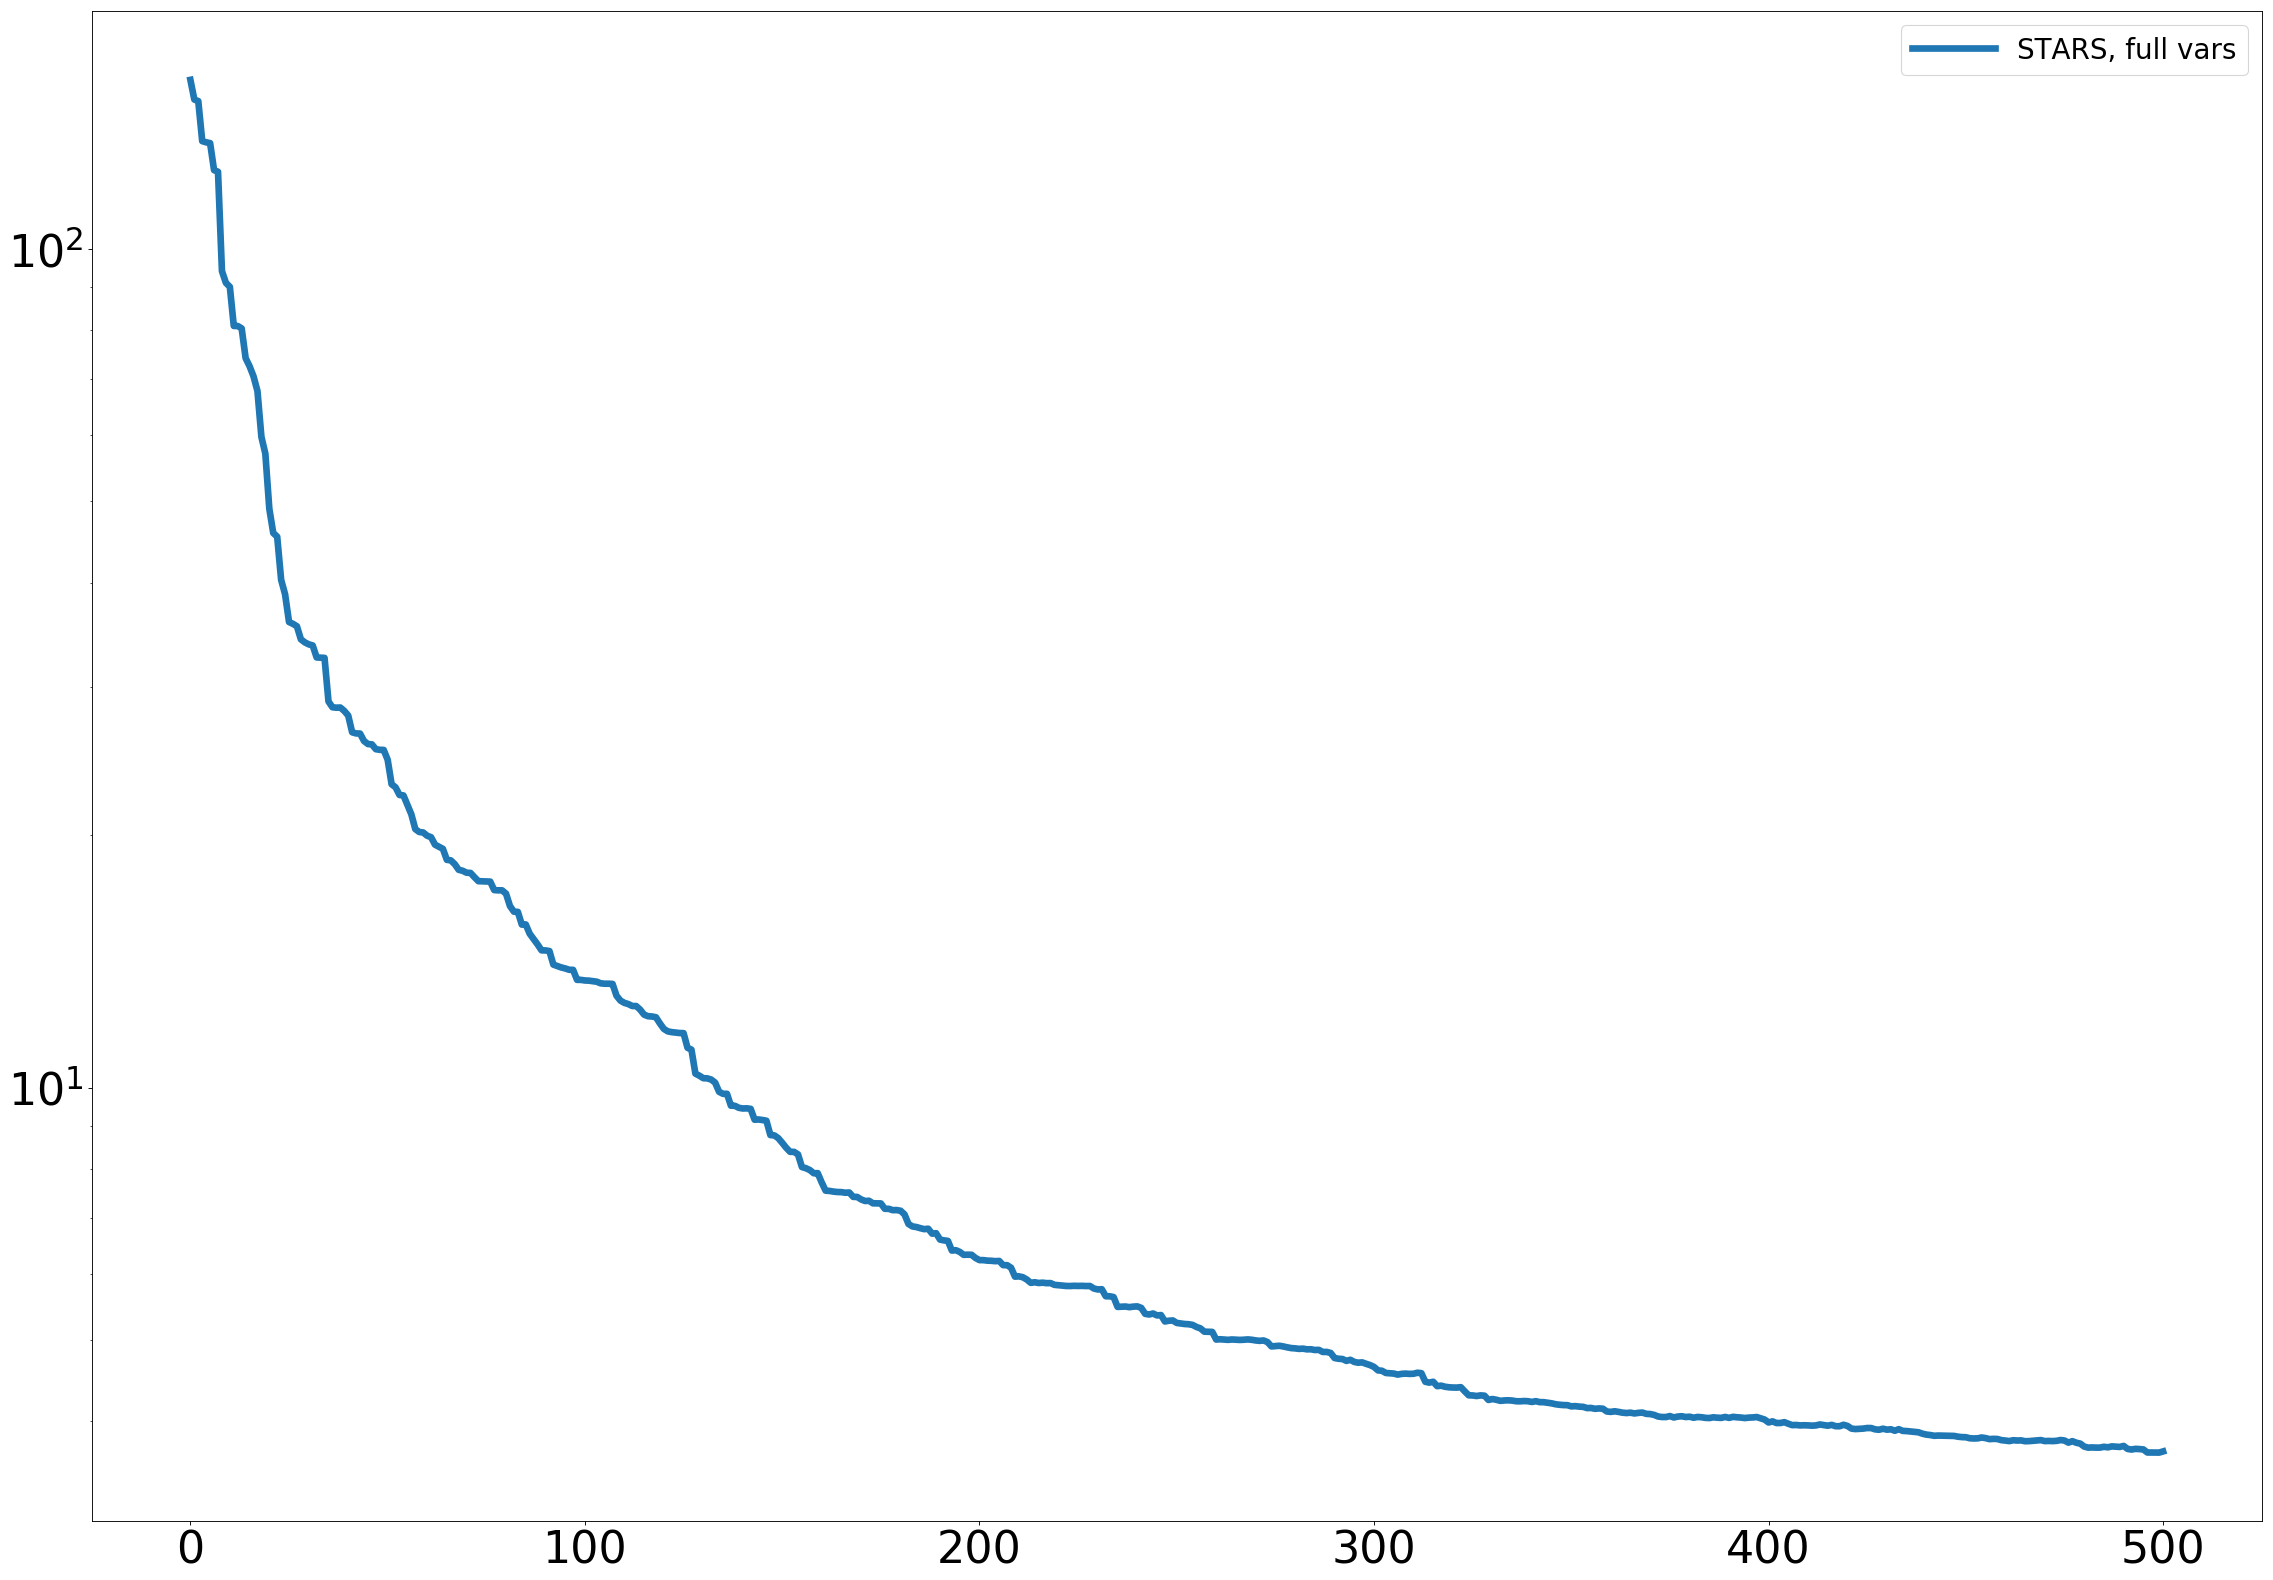

In [10]:
params = {'legend.fontsize': 25,
          'legend.handlelength': 3}
plt.rcParams["figure.figsize"] = (35,25)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 40
plt.rcParams['figure.titlesize'] = 'xx-large'
plt.rcParams.update(params)

plt.semilogy(fhist,lw=6,label='STARS, full vars')
plt.legend()
plt.show()

n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.
n should be an integer. Performing conversion.


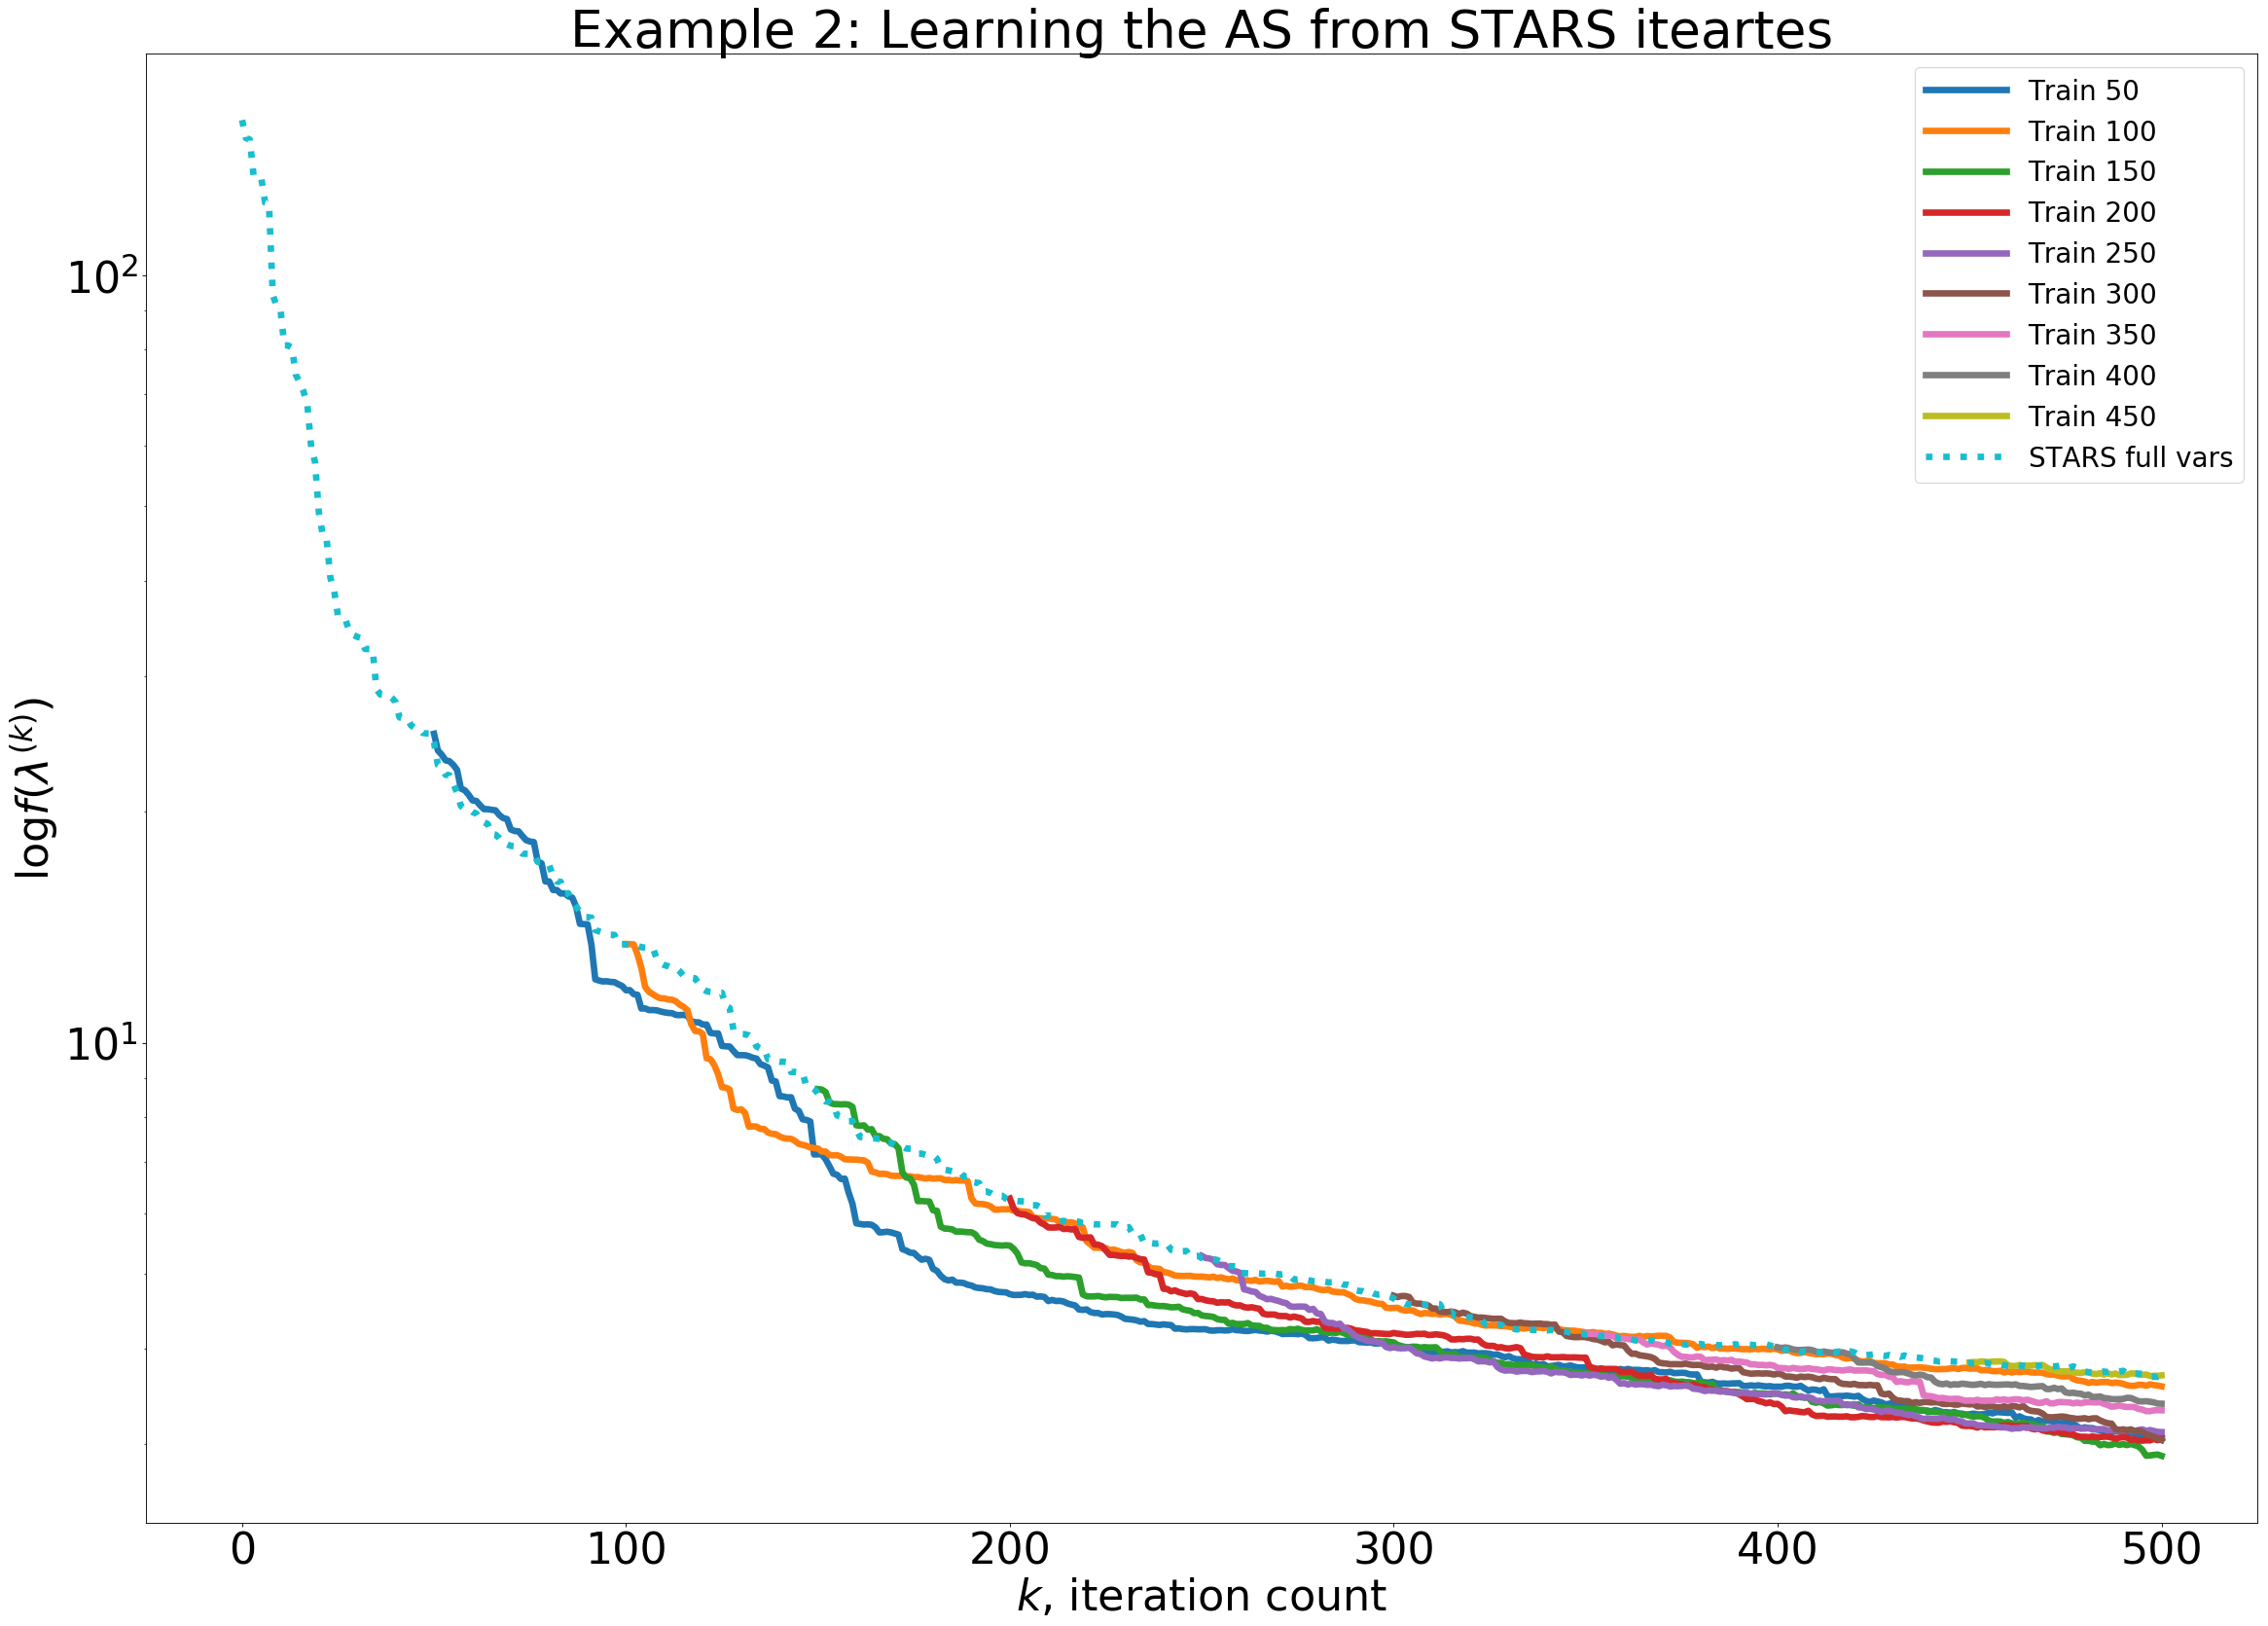

In [11]:
#plt.figure(figsize=(15,10))
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mu_star(mynoise,L_1_hat,6)
h=dfo.get_h(L_1_hat,6)

for tr_stop in range(50,500,50):

    trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,0:tr_stop]))
    trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
    trainx=np.transpose(trainx)


    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

    sub=ss.eigenvecs[:,0:dim]
 
    x4=np.transpose([xhist[:,tr_stop-1]])
    xhist4=np.array(x4)
    fhist4=np.array(tfun(x4))

    active=sub

    for i in range(0,500-tr_stop):
        [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=active)
        xhist4=np.hstack((xhist4,x4))
        fhist4=np.vstack((fhist4,f))
    plt.semilogy(range(tr_stop,501),fhist4,label='Train '+str(tr_stop),lw=6)


plt.semilogy(fhist, ls=':', lw=6, label='STARS full vars')

plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 2: Learning the AS from STARS iteartes')
plt.legend()
plt.show()

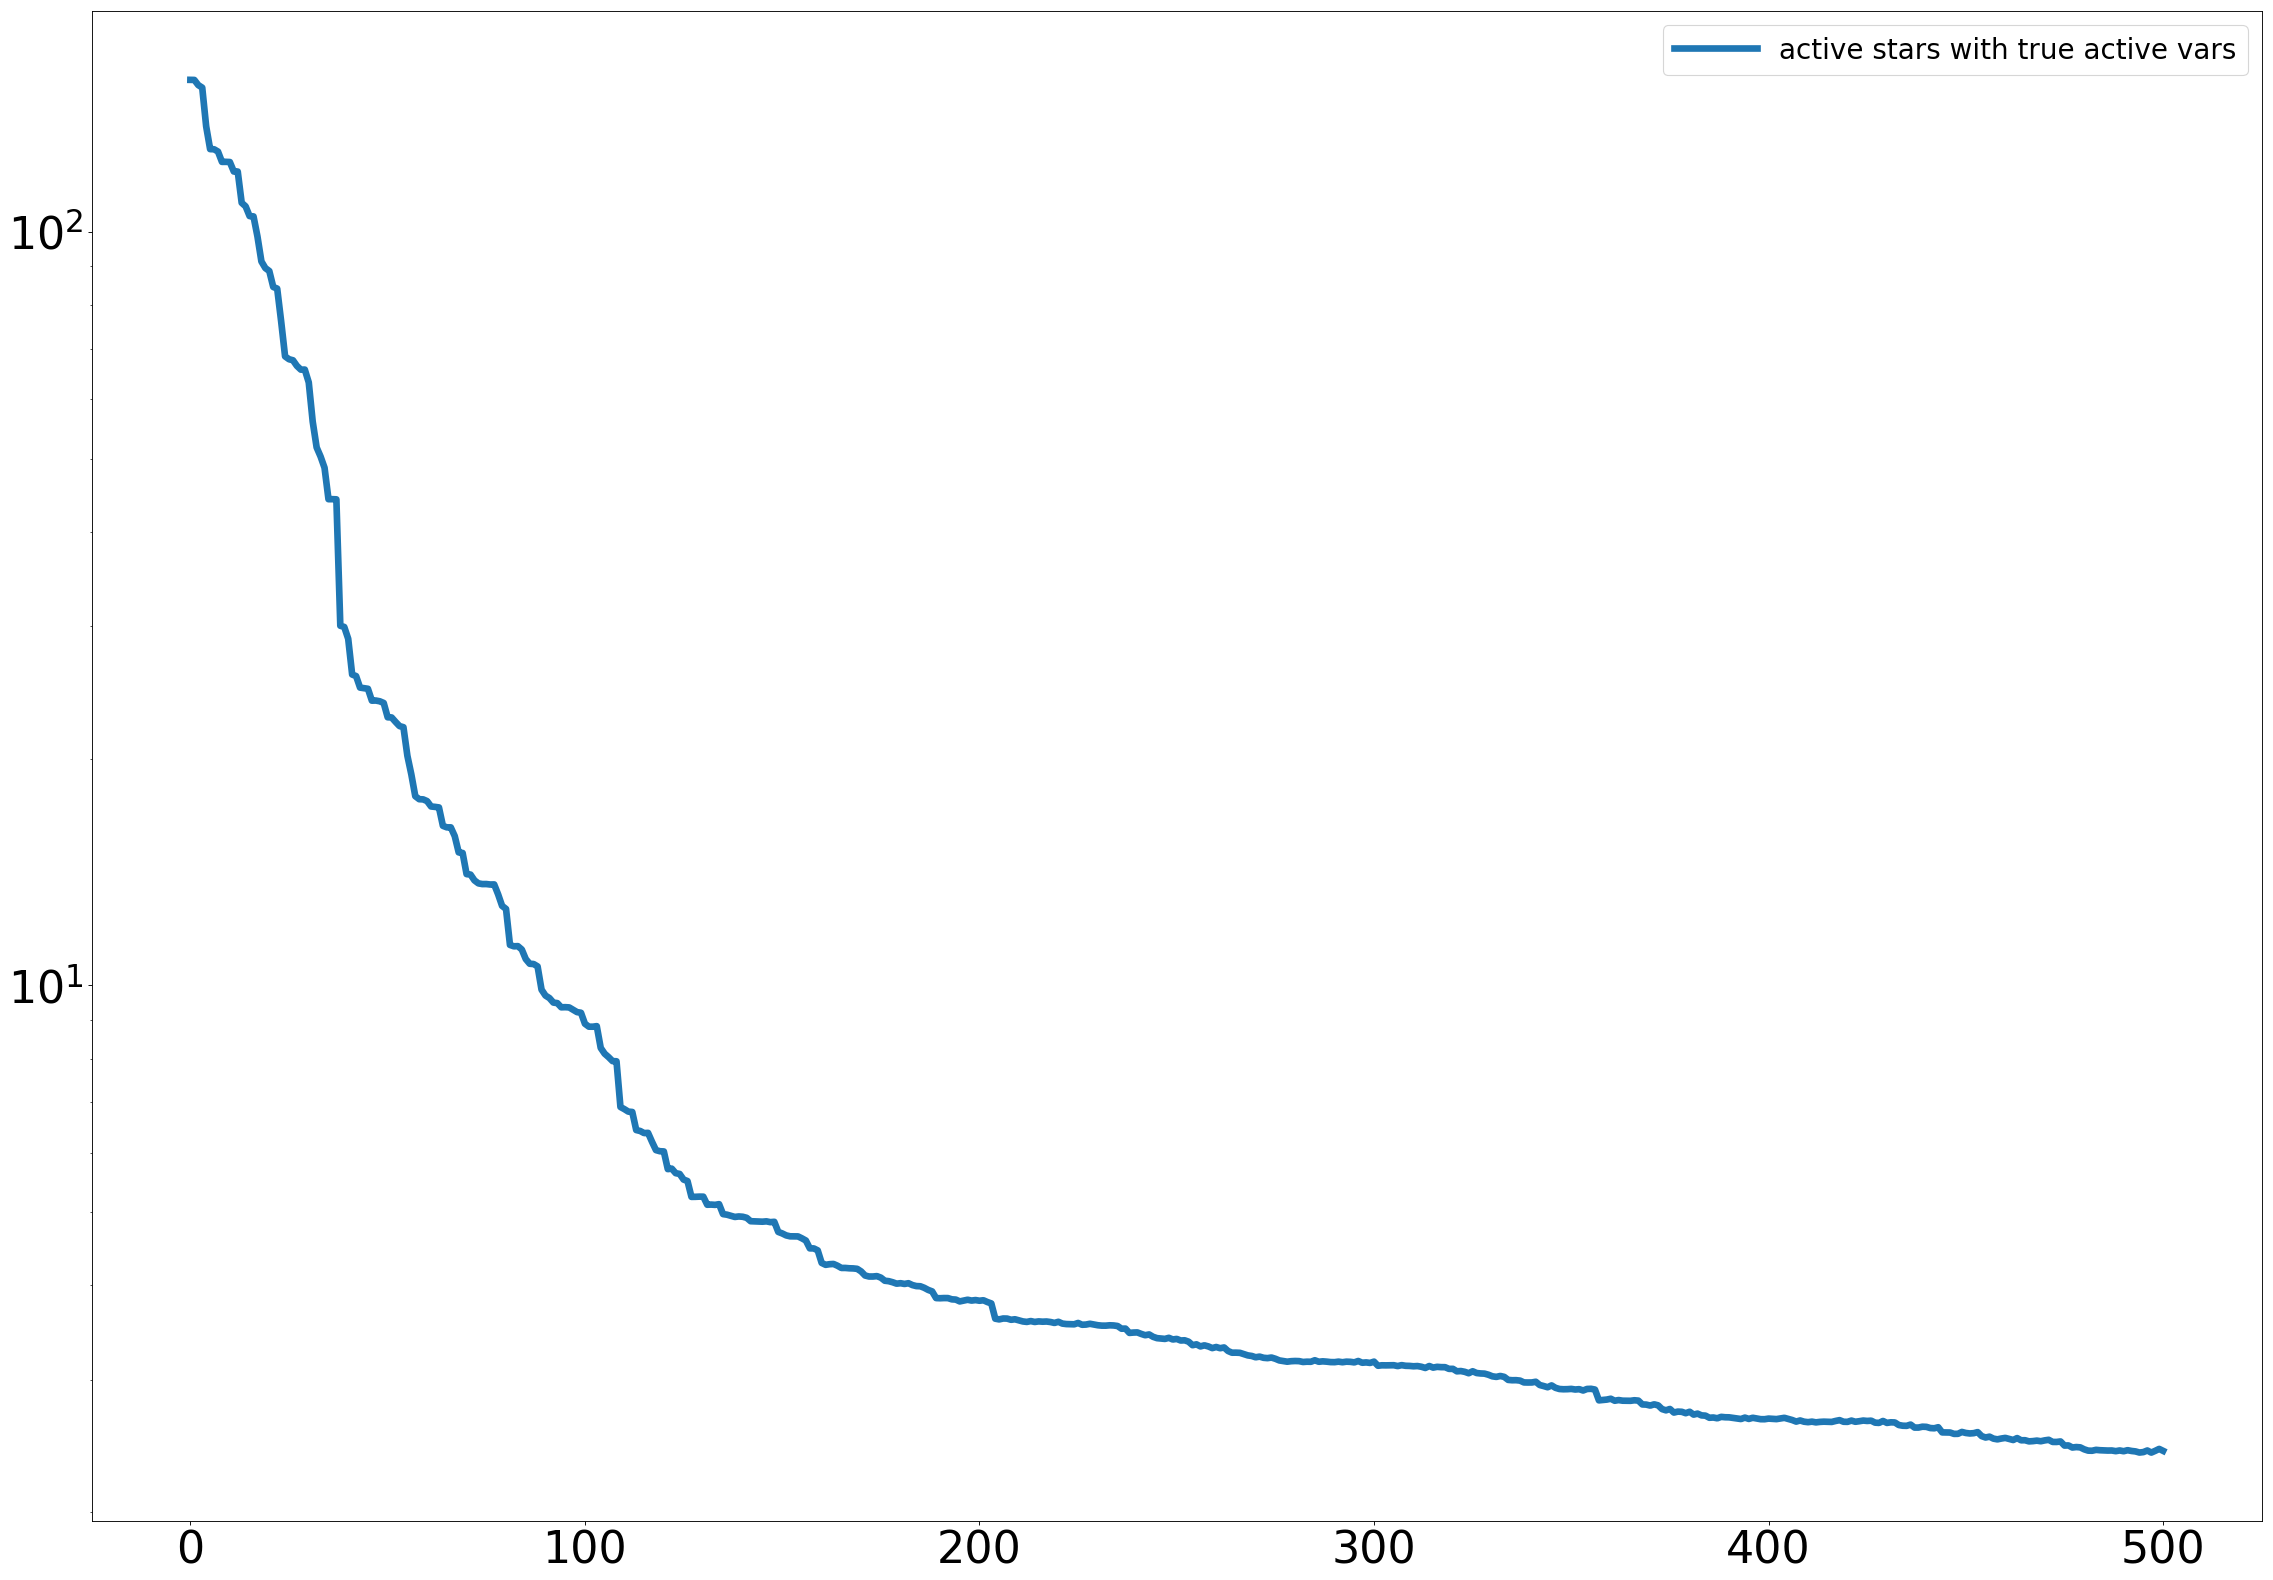

In [12]:
mu_star=dfo.get_mu_star(mynoise,L_1_hat,6)
h=dfo.get_h(L_1_hat,6)

x3=np.copy(xinit)
xhist3=np.array(x3)
fhist3=np.array(tfun(x3))

active=np.eye(dim)
active=np.transpose(active[[0,2,4,6,8,10],:])
eigenvals=np.transpose([[2**10,2**8,2**6,2**4,2**2,1]])


for i in range(500):
    [x3,f,temp1,temp2, p ,q,L1B]=dfo.STARS(x3,tfun,mu_star,h,active=active)
    xhist3=np.hstack((xhist3,x3))
    fhist3=np.vstack((fhist3,f))
    
plt.semilogy(fhist3,lw=6, label='active stars with true active vars')
plt.legend()
plt.show()

n should be an integer. Performing conversion.


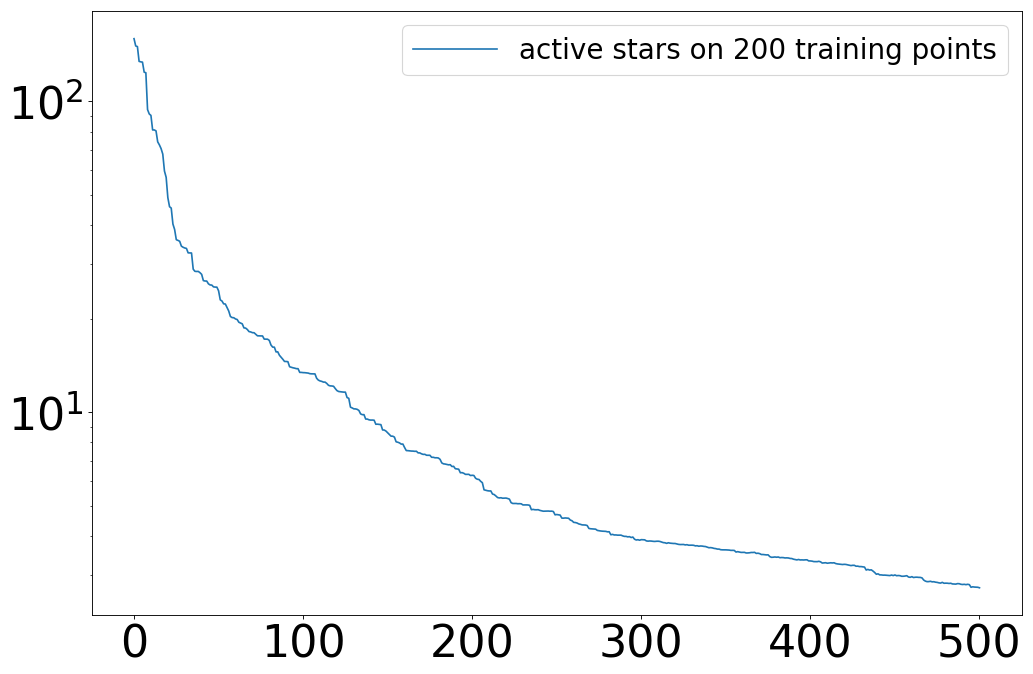

In [13]:
plt.figure(figsize=(15,10))
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)

tr_stop=200

trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,0:tr_stop]))
trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
trainx=np.transpose(trainx)



# Use Global Quadratic
ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

sub=ss.eigenvecs[:,0:dim]
 
x4=np.transpose([xhist[:,tr_stop-1]])
xhist4=np.array(x4)
fhist5=np.vstack((fhist[0:tr_stop],tfun(x4)))


for i in range(0,500-tr_stop):
    [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=sub)
    xhist4=np.hstack((xhist4,x4))
    fhist5=np.vstack((fhist5,f))
    #plt.semilogy(range(tr_stop,301),fhist4,label='Train '+str(tr_stop))


plt.semilogy(fhist5, label='active stars on 200 training points')
plt.legend()
plt.show()

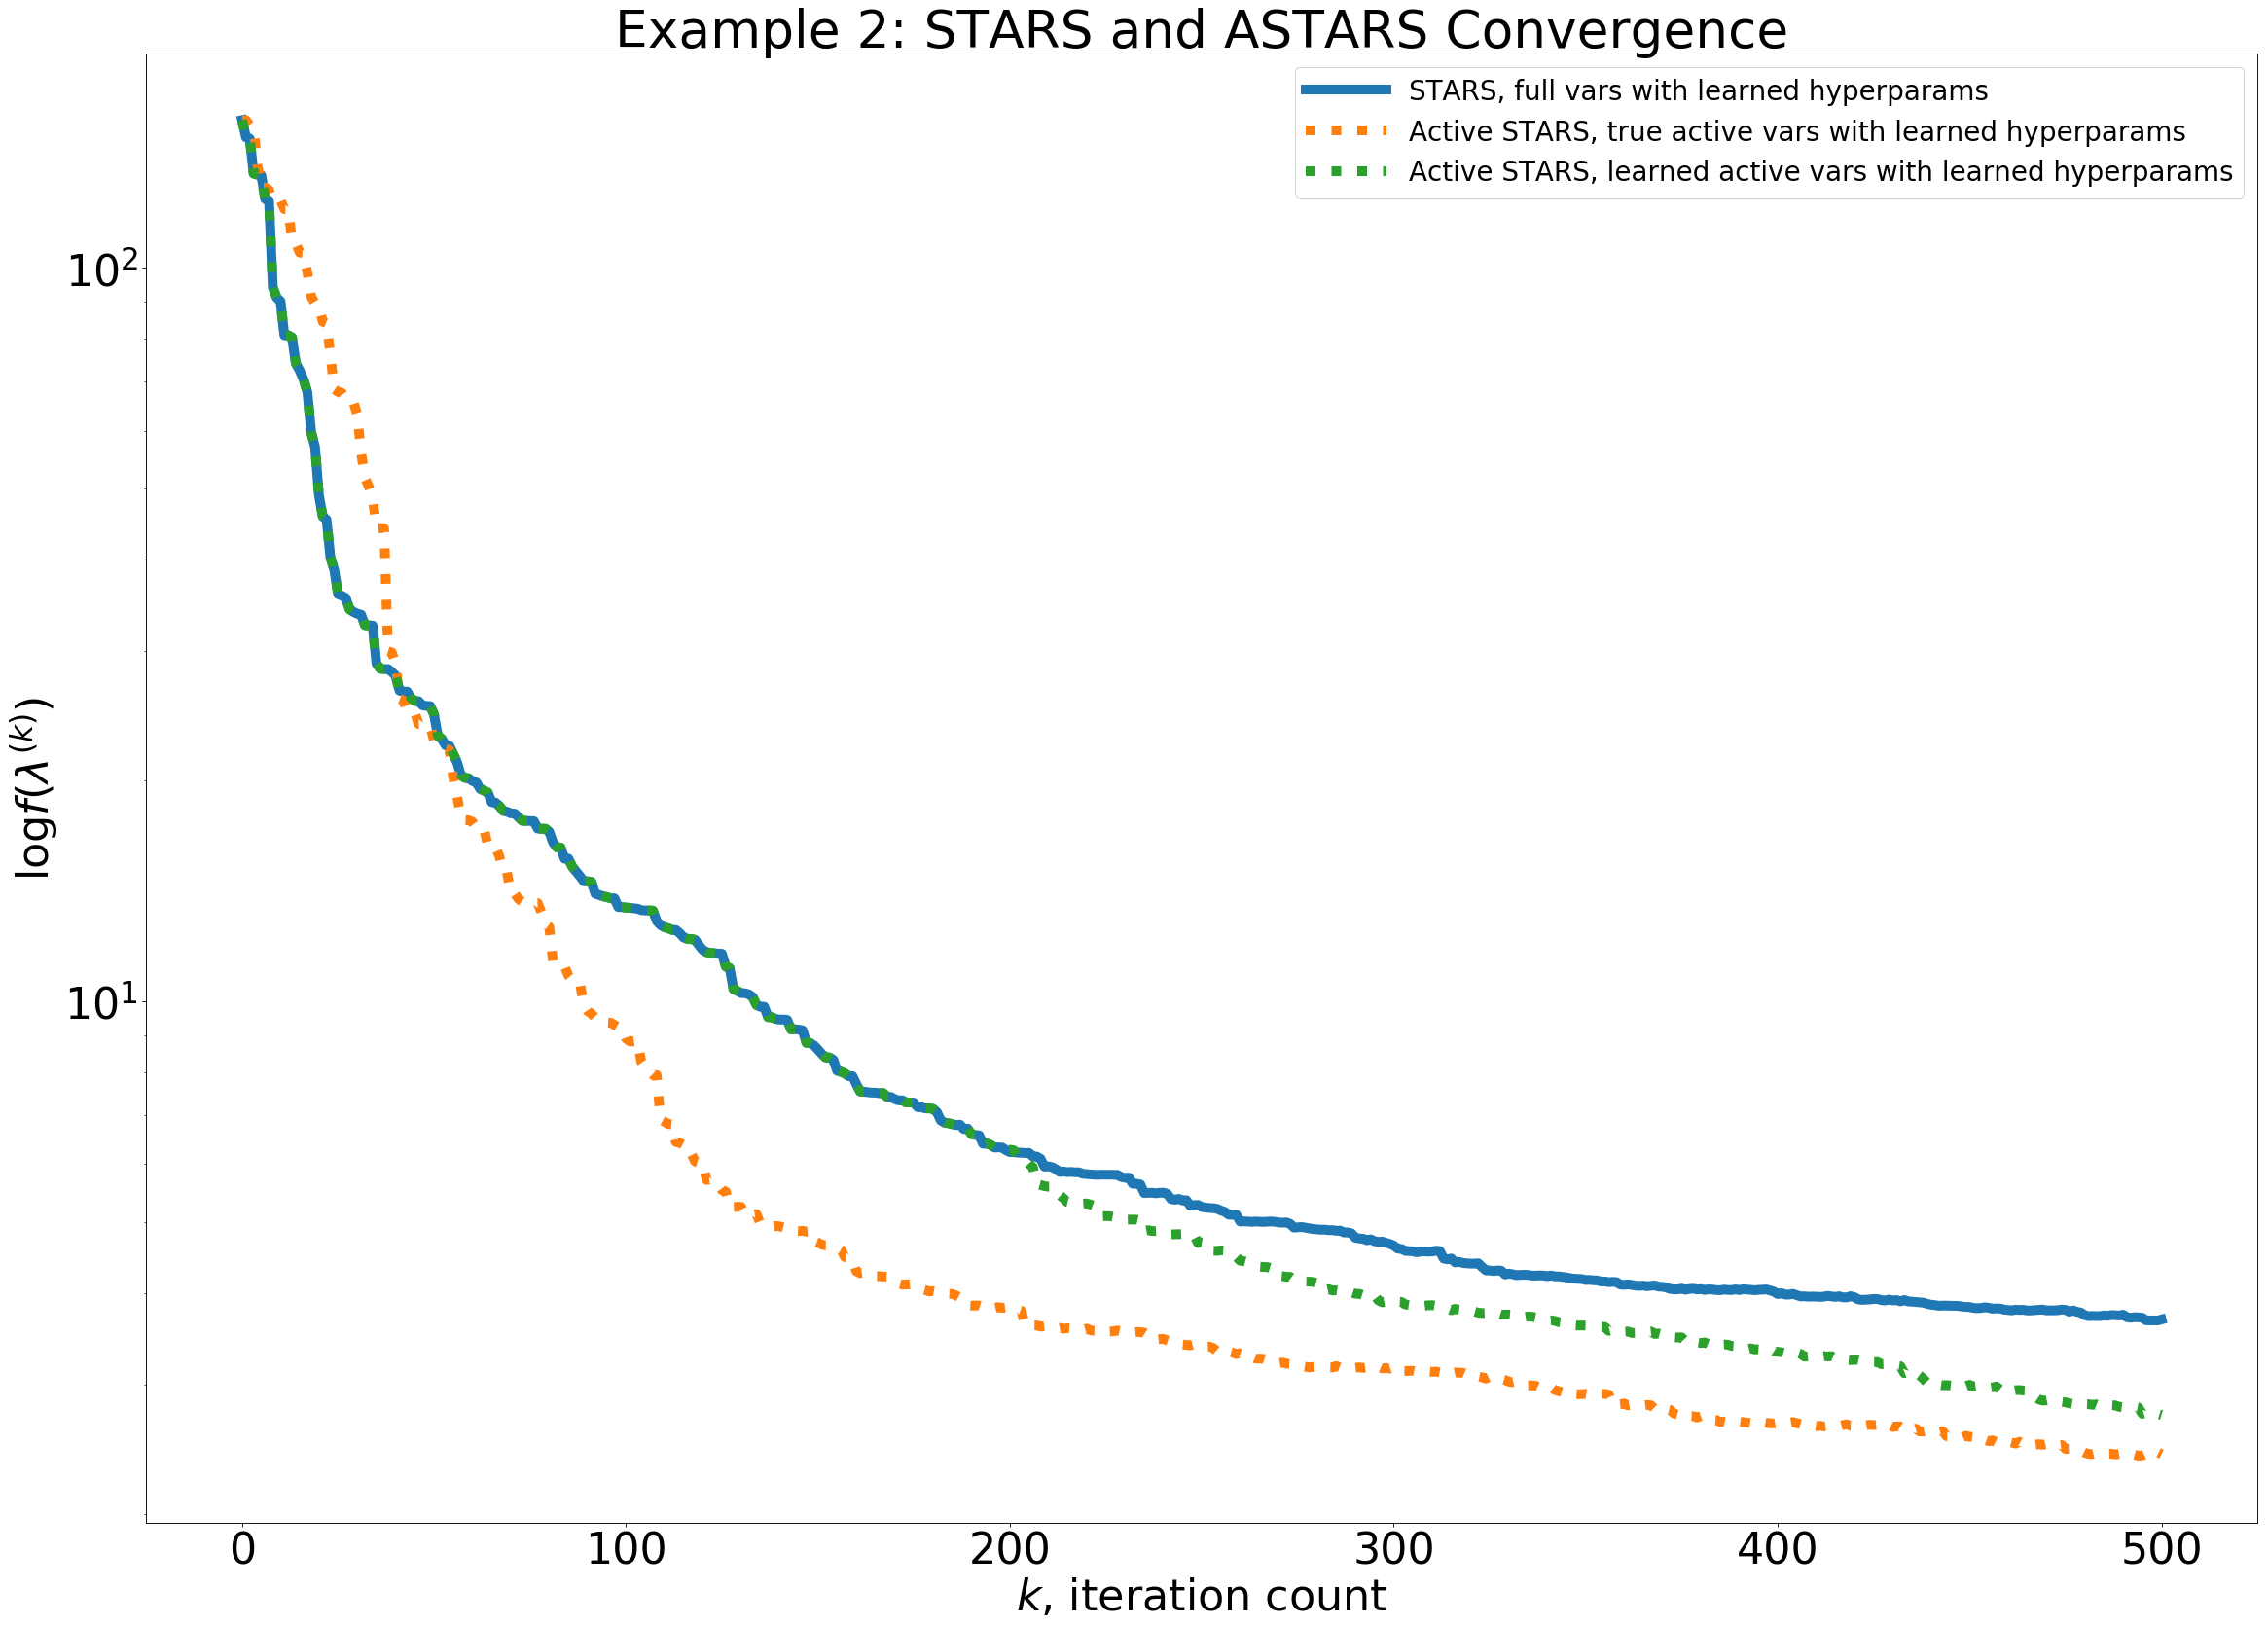

In [14]:
#plt.figure(figsize=(15,10))

plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 2: STARS and ASTARS Convergence')

plt.semilogy(fhist, lw=9, label='STARS, full vars with learned hyperparams')
plt.semilogy(fhist3, lw=9, ls=':',  label='Active STARS, true active vars with learned hyperparams')
plt.semilogy(fhist5, lw=9, ls=':',label='Active STARS, learned active vars with learned hyperparams')

plt.legend()
plt.show()